# Notebook que permite resolver el problema del Knapsack con valores asociados

En este Notebook se implementa el algoritmo que permite resolver el problema de la mochila, la idea es encontrar la configuración de objetos, cada uno asociado con un valor y un peso, que maximiza el valor total de los objetos seleccionados pero sin superar la capacidad C de la mochila.

Versiones:
- v1. Aprovechamiento de la sparsity del problema e implementación en GPU, sirve para resolver problemas donde cada objeto puede ser seleccionado i veces.
- v2. Aprovechamiento de la sparsity de los tensores generados teniendo en cuenta que solamente se forman dos diagonales no nulas, solo permite resolver el 0-1 knapsack
- v3. Limpieza del notebook <br>
    -v3.2 usando la libreria decimal
    
    

    


In [1]:
#Librerías
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
from time import time
from scipy.sparse import diags 
from ortools.algorithms.python import knapsack_solver
from decimal import Decimal, getcontext
from quantum_sim.main.guardar_experimentos import plot_function
from quantum_sim.main.guardar_experimentos import guardar_experimento
from quantum_sim.main.guardar_experimentos import media_por_posicion
from quantum_sim.main.guardar_experimentos import random_color_rgb
import matplotlib as plt
import matplotlib.pyplot as plt


---
# Funciones de la tensor network

## Definimos los nodos de la tensor network:

In [2]:

def tensor_initial_generator(peso: int, valor: int, n_elementos: int, capacidad: int,previous_weight_solution: int) -> tuple[csr_matrix, tuple[int]]:
    """
    Genera el primer tensor en formato sparse de la cadena.
    Parameters:
    - peso (int): Peso del primer elemento.
    - valor (int): Valor del primer elemento.
    - n_elementos (int): numero de veces que se repite el primer elemento, para el caso del 0-1 knapsack siempre vale uno.
    - capacidad (int): capacidad limite de la mochila.
    - previous_weight_solution (int): peso que se pasa desde arriba.
    Returns:
    - tensor: representación sparse del primer tensor.
    - tensor.shape: dimensionalidad del tensor

    """
    # Calculamos las dimensiones del tensor inicial
    tamaño_1 = min((capacidad - previous_weight_solution) // peso, n_elementos) + 1
    tamaño_2 = min(capacidad, (tamaño_1 - 1) * peso + previous_weight_solution) + 1
    # Creamos el tensor en formato sparse, solamente tiene dos elementos no nulos.
    tensor = np.zeros((tamaño_1, tamaño_2))
    tensor = np.array([[Decimal(str(val)) for val in row] for row in tensor], dtype=object)
    tensor[0,previous_weight_solution] = 1
    tensor[tamaño_1-1,tamaño_2-1] = valor
    return tensor, tensor.shape

def tensor_intermediate_generator(peso: int, n_elementos: int, capacidad: int, previous_weight: int) -> tuple[tuple[int], list[int]]:
    """
    Generador de los tensores intermedios, solamente se devuelven el número de elementos de cada diagonal no nula y la forma del tensor asociado.
    Parameters:
    - peso (int): Peso del elemento intermedio correspondiente.
    - n_elementos (int): numero de veces que se repite el elemento intermedio correspondiente, para el caso del 0-1 knapsack siempre vale uno.
    - capacidad (int): capacidad limite de la mochila.
    - previous_weight_solution (int): peso que se pasa desde arriba.
    Returns:
    - tensor.shape: dimensionalidad del tensor.
    - repetitions (list): numero de elementos no nulos que tienen ambas diagonales.

    """
    
    tamaño_1 = previous_weight
    tamaño_2 = min(capacidad, n_elementos * peso + previous_weight - 1) + 1
    tensor_shape = (tamaño_1,tamaño_2)
    c2=min(tamaño_2-peso,tamaño_1)
    repetitions=[tamaño_1,c2]
    return tensor_shape,  repetitions

def tensor_final_generator(peso:int, valor:int,n_elementos: int, capacidad: int, previous_weight:int) -> np.array:
    """
    Generador del ultimo tensor.
    Parameters:
    - peso (int): Peso del ultimo elemento.
    - valor (int): Valor del ultimo elemento.
    - n_elementos (int): numero de veces que se repite el ultimo elemento, para el caso del 0-1 knapsack siempre vale uno.
    - capacidad (int): capacidad limite de la mochila.
    - previous_weight_solution (int): peso que se pasa desde arriba.

    Returns:
    - tensor: vector del último tensor.
    """
    tamaño_1 = previous_weight
    tensor = np.zeros((tamaño_1))
    tensor = [Decimal(f"{t}") for t in tensor]
    for i in range(tamaño_1):
        n_elementos_posibles = min((capacidad -i)//peso,n_elementos)+1
        tensor[i] = valor**(n_elementos_posibles-1)  
    return tensor

## Función general que genera toda la información necesaria de la tensor network 

In [3]:
def tensor_generator(pesos:np.array, valores:np.array, n_elementos:np.array, capacidad:int) -> tuple[list[list], np.array]:
    """
    Función que determina el número de elementos no nulos de las diagonales de los tensores intermedios y el tensor que representa el último nodo de la cadena.
    Parameters:
    - pesos (np.array): array de pesos de todos los objetos.
    - valores (np.array): array de valores de todos los objetos.
    - n_elementos (np.array): array que indica el número de veces que se puede repetir cada objeto, para el caso del 0-1 knapsack siempre vale uno.
    - capacidad (int): capacidad limite de la mochila.

    Returns:
    - repeticiones = lista que incluye el número de elementos no nulos de cada tensor intermedio.
    - tensor (np.array) = vector que representa el último nodo de la cadena.
    """
    repeticiones = []
    n_clases = len(pesos)
    tensor,tensor_shape = tensor_initial_generator(pesos[0],valores[0],n_elementos[0],capacidad,0)
    repeticiones.append([1,1])
    for node in range(1, n_clases-1):
        tensor_shape,repetitions = tensor_intermediate_generator(pesos[node], n_elementos[node], capacidad, tensor_shape[1])
        repeticiones.append(repetitions)
    tensor = tensor_final_generator(pesos[-1], valores[-1], n_elementos[-1], capacidad, tensor_shape[1])
    return repeticiones,tensor

## Función de contracción de los tensores

In [4]:

def tensor_contraction(valores, pesos, repetitions, vector) -> tuple[np.array, list[list]]:
    """
    Funcion que contrae la tensor network y almacena los cálculos intermedios.
    Parameters:
    - pesos (np.array): array de pesos de todos los objetos.
    - valores (np.array): array de valores de todos los objetos.
    - repetitions: lista que contiene el número de elementos no nulos de cada tensor intermedio.
    - vector (np.array): vector que representa el último nodo de la cadena. 
    Returns:
    - last_tensor (np.array): tensor final despues de la contracción.
    - tensores_intermedios (list[list])
    """
    n_tensores = len(valores)
    tensores_intermedios = []
    tensores_intermedios.append(vector)
    current_tensor = vector
    #iteramos y contraemos sobre cada nodo de la cadena hasta el primer nodo, guardando en el proceso el tensor resultante de la contracción.
    for node in range(n_tensores - 2, 0, -1):
        n_elements_diag1 = repetitions[node][0]
        n_elements_diag2 = repetitions[node][1]
        current_tensor = multiplication(valores[node],n_elements_diag1,n_elements_diag2,pesos[node],current_tensor)
        tensores_intermedios.append(current_tensor)
        #Si el elemento del tensor supera un cierto umbral lo dividiremos por un cierto valor para que no se produzca overflow
       
        if current_tensor[0] > 1e200:
            for i,element in enumerate(current_tensor):
                current_tensor[i] = element /Decimal(f"{current_tensor[0]}")  

    # Contraccion con el primer nodo, este presenta una estructura diferente al resto
    last_tensor = np.array([current_tensor[0],current_tensor[-1]])
    tensores_intermedios.append(last_tensor)
    tensores_intermedios.reverse()
    return last_tensor, tensores_intermedios


def multiplication(diagonal_value, n_elements_diag1, n_elements_diag2, peso, vector) -> np.array:

    """
    Funcion auxiliar que simula la multiplicación de un vector denso por una matriz de elementos nulos excepto en dos diagonales.
    Parameters:
    - diagonal_value (int): valor del elemento de la segunda diagonal del tensor intermedio.
    - n_elements_diag1 (int): numero de elementos de la primera diagonal.
    - n_elements_diag2 (int): numero de elementos de la segunda diagonal.
    - peso (int): peso del objeto a multiplicar, este valor implica la columna en la que empieza la segunda diagonal. 
    Returns:
    - (np.array): vector que se obtiene al contraer el nodo y el vector denso.

    """
    # vector copia del denso de menor dimension.
    result = vector[:n_elements_diag1]
    # vector denso desplazado y multiplicado por el valor.
    diag_2 = np.zeros(n_elements_diag1)
    diag_2 = [Decimal(f"{t}") for t in diag_2]
    diag_2[:n_elements_diag2] = vector[peso:peso+n_elements_diag2]
    # Realiza la multiplicación
    # Multiplicar por diagonal_value
    for k in range(n_elements_diag1):
        diag_2[k] =diag_2[k]*diagonal_value
        result[k] = diag_2[k]+result[k]
    return result+diag_2


## Función general

In [5]:

def solver(pesos: np.array, valores: np.array, n_elementos: np.array, capacidad: int, tau: float) -> tuple[np.array, float]:
    """
    Funcion global que permite computar el problema de la mochila con capacidad C a partir de unos pesos, valores y numero de veces que se repite cada clase.
    Parameters:
    - pesos (np.array): array de pesos de todos los objetos.
    - valores (np.array): array de valores de todos los objetos.
    - n_elementos (np.array): array que indica el número de veces que se puede repetir cada objeto, para el caso del 0-1 knapsack siempre vale uno.
    - capacidad (int): capacidad limite de la mochila.
    - tau (flat): parametro que determina la constante de la evolucion en tiempo imaginario
    Returns:
    - last_tensor (np.array): tensor final despues de la contracción.
    - tensores_intermedios (list[list])
    """
    # inicializacion de variables
    valores_scaled = np.exp(valores * tau)
    valores_scaled = [Decimal(str(valor)) for valor in valores_scaled]
    
    n_clases = len(pesos)
    solution = np.zeros(n_clases)
    # generamos la tensor network aprovechando la sparsity del problema (solo se necesita el tamaño de las diagonales de los tensores intermedios)
    repetitions, vector_final = tensor_generator(pesos, valores_scaled, n_elementos, capacidad)
    # contraemos la tensor network, guardando los tensores intermedios para obtimizar calculos.
    vector_salida, tensores_intermedios = tensor_contraction(valores_scaled, pesos, repetitions, vector_final)
 
  
    # obtencion del resultado del primer objeto
    solution[0] = np.argmax(abs(vector_salida))
    # iteeracion en los nodos intermedios para obtener los resultados de los elementos intermedios
    for node in range(1, n_clases - 1):
        tensores_intermedios.pop(0)
        cumulative_weight = int(np.dot(solution[:node], pesos[:node]))
        new_initial_tensor,tensor_shape = tensor_initial_generator(pesos[node], valores_scaled[node], n_elementos[node], capacidad, cumulative_weight)
        solution[node] = np.argmax(abs(new_initial_tensor @ tensores_intermedios[1][:tensor_shape[1]]))
    # obtencion del resultado del ultimo objeto
    cumulative_weight = np.dot(solution[:-1], pesos[:-1])
    solution[-1] = min((capacidad - cumulative_weight) // pesos[-1], n_elementos[-1])
    return solution

## Funciones auxiliares para la realización de las pruebas

In [6]:
def mochila_greedy(pesos, valores, capacidad, n_elementos):
    """
    Función que permite resolver el problema del knapsack empleando el algoritmo greedy, basicamente consiste en ordenar los elementos de la mochila de manera ascendente 
    en funcion del ratio valor/peso e ir seleccionando objetos hasta que llenen al maximo la mochila.
    """
    n_clases = len(pesos)
    # Calculamos la relación valor/peso para cada clase
    valor_peso = valores / pesos
    # Ordenamos los elementos por su valor/peso de mayor a menor
    indices_ordenados = np.argsort(valor_peso)[::-1]  # Orden descendente
    # Inicializamos variables
    peso_actual = 0
    valor_actual = 0
    solucion = np.zeros(n_clases, dtype=int)
    # Recorremos los objetos en orden greedy
    for i in indices_ordenados:
        # Tomamos la mayor cantidad posible de este objeto sin exceder la capacidad
        cantidad = min(n_elementos[i], (capacidad - peso_actual) // pesos[i])
        solucion[i] = cantidad
        peso_actual += cantidad * pesos[i]
        valor_actual += cantidad * valores[i]
        # Si llenamos la capacidad, salimos del bucle
        if peso_actual >= capacidad:
            break
    return solucion, valor_actual


In [7]:
def google_solver(valores, pesos, capacidad):
    solver = knapsack_solver.KnapsackSolver(
    knapsack_solver.SolverType.KNAPSACK_MULTIDIMENSION_BRANCH_AND_BOUND_SOLVER,"KnapsackExample",)
    solver.init(valores, [pesos], [capacidad])
    computed_value = solver.solve()
    packed_items = []
    packed_weights = []
    total_weight = 0
    print("Total value =", computed_value)
    for i in range(len(valores)):
        if solver.best_solution_contains(i):
            packed_items.append(i)
            packed_weights.append(pesos[i])
            total_weight += pesos[i]
    print("Total weight:", total_weight)



In [8]:
def leer_archivo_knapsack(ruta_archivo):
    """
    Funcion que permite parsear los problemas de un github que contiene instancias de problemas knapsack a el input que toma el algoritmo de tensor network.
        """
    with open(ruta_archivo, 'r') as archivo:
        lineas = archivo.readlines()
    # Limpiar líneas en blanco
    lineas = [linea.strip() for linea in lineas if linea.strip()]
    # Número de clases (primera línea)
    clases = int(lineas[0].strip())
    # Listas para almacenar los pesos y valores
    pesos = []
    valores = []
    # Leer ítems (líneas desde la 2 hasta la penúltima)
    for linea in lineas[1:-1]:  # Excluimos la primera y la última línea
        datos = linea.split()
        if len(datos) != 3:
            print(f"Advertencia: Línea no tiene 3 valores: {linea}")
            continue  # O puedes manejar este caso según sea necesario
        id_, peso, valor = datos
        pesos.append(int(peso))
        valores.append(float(valor))
    # Capacidad de la mochila (última línea)
    capacidad = int(lineas[-1].strip())
    return clases, pesos, valores, capacidad


In [159]:
# descomentar estas lineas y comenar las siguientes si queremos resolver los problemas dados por la libreria de Github.
# ruta = '/home/sergio/simulador/Simulador_Cuantica/quantum-sim/TensorNetwork/knapsack/knapsackProblemInstances/problemInstances/n_400_c_1000000_g_2_f_0.1_eps_0_s_100/test.in'
# clases, pesos, valores, capacidad = leer_archivo_knapsack(ruta)
#np.random.seed(5234)
clases = 300
pesos = np.random.randint(1,10,clases)

valores = np.random.rand(clases)
n_elementos = [1]*clases
max_capacity = sum(pesos*n_elementos[0])
print(int(round(max_capacity*0.7)))

tau = 700
#valores = valores2/10

solution=solver(pesos,valores, n_elementos, int(round(max_capacity*0.7)), tau)
#print("Mejor solución encontrada:", solution)
print("Valor total de la mejor solución:", np.dot(solution, valores))
print("Peso total de la mejor solución:", np.dot(solution, pesos))

mejor_solucion, mejor_valor = mochila_greedy(pesos, valores, int(round(max_capacity*0.7)), n_elementos)
#print("Mejor solución encontrada (greedy):", mejor_solucion)
print("Valor total de la mejor solución (greedy):", np.dot(mejor_solucion, valores))
print("Peso total de la mejor solución (greedy):", np.sum(mejor_solucion * pesos))

#knapsack.knapsack(pesos, valores).solve(int(round(max_capacity*0.7))) ## Este no funciona
res = solve_single_knapsack(valores, pesos, int(round(max_capacity*0.7)),method='mt1r')
print("Valor total de la mejor solución res:", np.dot(res, valores))
print("Peso total de la mejor solución res:", np.sum(res * pesos))

1053
Valor total de la mejor solución: 140.95884548424235
Peso total de la mejor solución: 1053.0
Valor total de la mejor solución (greedy): 140.9131870438942
Peso total de la mejor solución (greedy): 1053
Valor total de la mejor solución res: 140.95884548424235
Peso total de la mejor solución res: 1053


In [64]:

res = solve_single_knapsack(profits, weights, capacity)

In [38]:
print(sum(solution!=mejor_solucion))

2


## Experimentación

En esta parte del Notebook desarrollamos los experimentos relacionados con el algoritmo de tensor network del knapsack

In [29]:
import matplotlib.pyplot as plt
import random
from time import time
def guardar_experimento(nombre_archivo, descripcion_experimento, precision,tau, max_values,timet,capacity):
    with open(nombre_archivo, 'a') as file:
        file.write(f"Descripción del experimento: {descripcion_experimento}\n")
        file.write(f"Precisión: {precision}\n")
        file.write(f"Valores tau: {tau}\n")
        file.write(f"Valores máximos: {max_values}\n")
        file.write(f"tiempos: {timet}\n")
        file.write(f"capacidad: {capacity}\n")
        file.write("="*40 + "\n")
        
def tau_experimento(clases,capacidad,pesos,valores,n_elementos,tau,lambda1,experimento):
   precision=[]
   max_values=[]
   time = []
   for t in tau:
      inicio = time()
      p1,v1,max=solver(pesos,valores,n_elementos,capacidad,t,lambda1)
      fin = time()
      tiempo = fin-inicio
      p2,v2 = mochila_greedy(pesos,valores,capacidad,n_elementos)
      time.append(tiempo)
      precision.append(v1/v2)
      max_values.append(max)
   random_color = (random.random(), random.random(), random.random())
   plt.plot(tau, precision, marker='o', color=random_color, linestyle='-')  # 'o' para puntos, 'b' para color azul, '-' para línea sólida
   plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.8)
   # Añadir etiquetas y título
   plt.xlabel(r"$\tau$")
   plt.ylabel("precision")
   plt.title("Gráfico de línea con dos listas")
   #plt.savefig(f"grafico_precision_{experimento}.png", format="png", dpi=300)
   nombre_archivo = f"resultados_experimentos.txt"
   descripcion_experimento = f"Experimento {experimento}, clases={clases} con min_tau={tau[0]} ,max_tau={tau[-1]},capacidad={int(0.75*(clases)*n_elementos[0])},n_elementos={n_elementos}, tiempo ={time}"
   guardar_experimento(nombre_archivo, descripcion_experimento, precision,tau, max_values,capacidad)
   return precision,max_values

In [30]:

from time import time
import random
import matplotlib as plt
np.random.seed(1)
clases = 100
pesos = np.random.randint(1,10,clases)
valores = np.random.rand(clases)
n_elementos = [1]*clases
clase = []
tau = []
precition = []
max_capacity = sum(pesos*n_elementos[0])

n_inter = 20
t = np.linspace(0,30,n_inter)
for tao in t:
    tau.append(tao)
    solution,max=solver(pesos,valores,n_elementos,int(np.round(max_capacity*0.8)),tao)
    best_value = np.dot(solution, valores)
    mejor_solucion, mejor_valor = mochila_greedy(pesos, valores, int(np.round(max_capacity*0.8)), n_elementos)
    precition.append(best_value/mejor_valor)
print(precition)
random_color = (random.random(), random.random(), random.random())
plt.plot(tau, precition, marker='o', color=random_color)  # 'o' para puntos, 'b' para color azul, '-' para línea sólida
plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.8)
# Añadir etiquetas y título
plt.xlabel("capacidad en porciento")
plt.ylabel("tiempo")
plt.title("Gráfico de línea con dos listas")
#plt.savefig(f"grafico_precision_{experimento}.png", format="png", dpi=300)
nombre_archivo = f"resultados_experimentos.txt"
descripcion_experimento = f"Experimento tiempo en función de clase, clases={clases}, pesos ={pesos}, valores = {valores} con tau={tau},n_elementos={n_elementos[0]}"
guardar_experimento(nombre_archivo, descripcion_experimento, precition,tau)



[0.01983763905750727, 0.9764143621690201, 0.9903620973022018, 0.9966101404707302, 0.9966101404707302, 0.9985565534674381, 0.9985565534674381, 0.9976991590529602, 0.9963075566679626, 0.9988907542007145, 0.9985760197520673, 0.9985760197520673, 0.9985760197520673, 0.9985760197520673, 0.9999999999999998, 0.9999999999999998, 0.9999999999999998, 0.9999999999999998, 0.9999999999999998, 0.9999999999999998]


AttributeError: module 'matplotlib' has no attribute 'plot'

In [54]:
def exp_error_tau(c_i: list, num_clases: int, n_iter: int, max_tau: float):
    """Experimento que permite realizar el experimento de determinar el error relativo en funcion del tau

    Args:
        num_clases (int): _description_
        n_elementos (int): _description_
        n_iter (int): _description_
    """

    pesos = np.random.randint(1,10,num_clases)
    valores = np.random.rand(num_clases)
    tau = []
    precition=[]
    
    tau_range = np.linspace(20,max_tau,n_iter)
    for n_elementos_ci in c_i:
        tau_aux =[]
        precition_aux = []
        n_elementos=[n_elementos_ci]*num_clases
        valores_aux = valores/n_elementos_ci
        max_capacity = sum(pesos*n_elementos[0])
        for  tau_index in tau_range:
            tau_aux.append(tau_index)
            solution = solver(pesos, valores_aux,n_elementos, int(round(max_capacity*0.5)), tau_index)
            valor_tn = np.dot(solution, valores)
            solution_greedy, valor_greedy = mochila_greedy(pesos, valores, int(round(max_capacity*0.5)), n_elementos)
            precition_aux.append(1-valor_tn/valor_greedy)
        precition.append(precition_aux)
        tau.append(tau_aux)
    return tau, precition

In [97]:
c_i = [1]
np.random.seed(67)
tau, precition = exp_error_tau(c_i, num_clases=100, n_iter=50, max_tau=700)



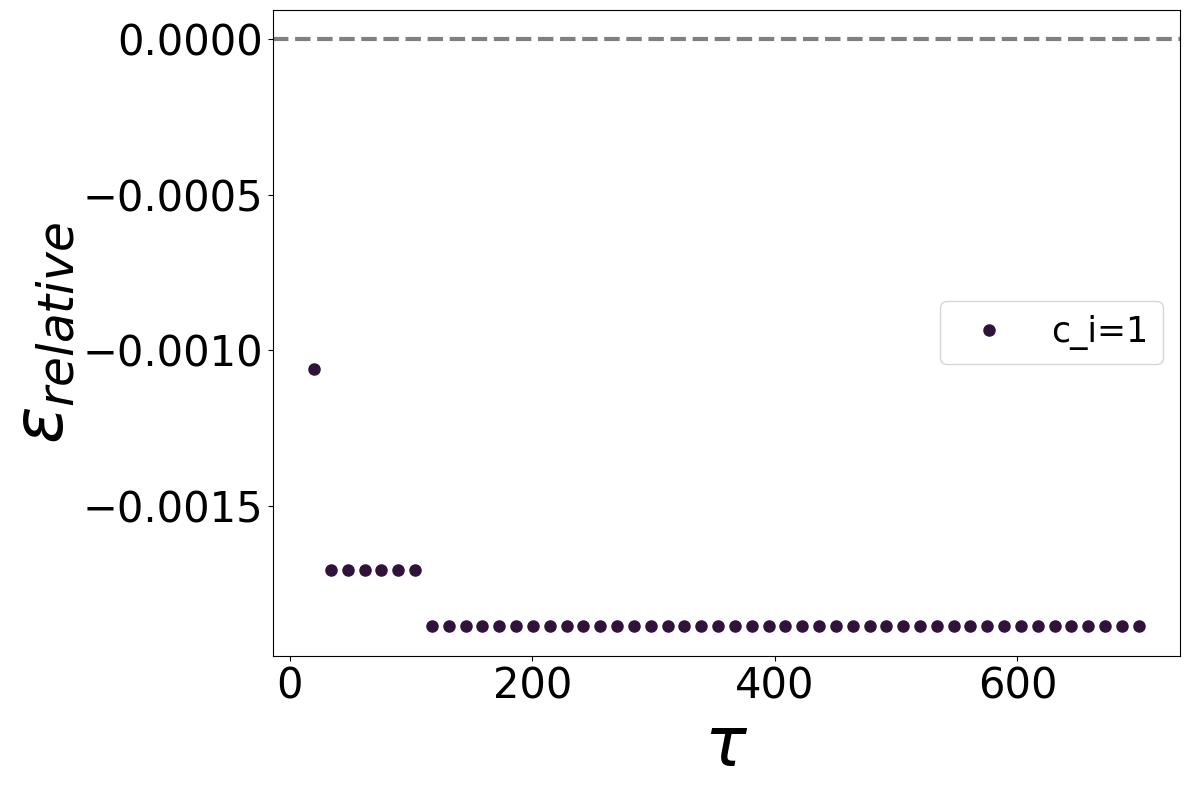

In [98]:
np.random.seed(5)
marker_list = ['o','s','v','*','d', 'P', 'X', '^']
cmap = plt.cm.turbo
gradient = np.linspace(0, 1, 2)
for c_ii in range(len(c_i)):
    plot_function(tau[c_ii], precition[c_ii], r"$\tau$", r"$\epsilon_{relative}$", titulo="tau-error.pdf", color = cmap(gradient[c_ii]), etiqueta=f"c_i={c_i[c_ii]}", marker=marker_list[c_ii])

(25, [0, 3, 8, 9])